<a href="https://colab.research.google.com/github/Rogerio-mack/fNIRS/blob/main/fnirs_analysis_3b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sumário

Inspeciona dados de Raw Data fNIRS (obtidos em Excel com o Matlab), incluindo a aplicação de filtros passa-baixa.



# Mount Google Drive

Para acesso aos arquivos compartilhados. Tenha certeza de ter adicionado a pasta compartilhada ao seu Google Drive antes.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Common Imports

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from itertools import compress



In [3]:
#@markdown **def suboutines**
#@markdown ---
#@markdown * plotchannels(df, ncols_display=5, title='Display Channels') 
#@markdown > *plot raw data from each channel*
#@markdown * def remove_outlier(df_in, col_name)
#@markdown > *remove outliers from a single channel*

def plotchannels(df, ncols_display=3, title='Display Channels'):
  nr_channels = len(df.columns)
  ncols= ncols_display
  nrows= int(nr_channels/ncols + 1)

  fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=False, figsize=(ncols*5,nrows*3.5))

  i = 0
  for c in df:
    ax[i//ncols,i%ncols].plot(df.index, df[c], color=['blue','red'][df[c].min() < 0] )
    ax[i//ncols,i%ncols].set_title(c, fontsize=16, weight='bold')
    i = i + 1
    plt.xticks([])
  
  plt.suptitle(title, fontsize=14, weight='bold')
  plt.show()

  return

def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out  

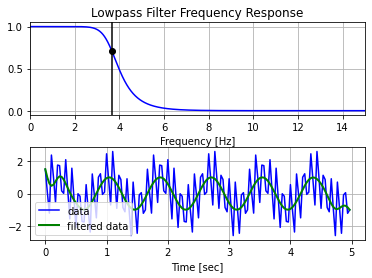


cutoff....  3.667
fs........  30.0
order.....  6



In [4]:
#@markdown **def suboutines**
#@markdown ---
#@markdown * def butter_lowpass_filter(data, cutoff, fs, order=5) 
#@markdown > *lowpass filter data from a single channel*


# https://stackoverflow.com/questions/25191620/
#   creating-lowpass-filter-in-scipy-understanding-methods-and-units

import numpy as np
from scipy.signal import butter, lfilter, freqz, filtfilt
from matplotlib import pyplot as plt


def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a


def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
#    y = lfilter(b, a, data)
    y = filtfilt(b, a, data)
    return y


# Filter requirements.
order = 6
fs = 30.0       # sample rate, Hz
cutoff = 3.667  # desired cutoff frequency of the filter, Hz

# Get the filter coefficients so we can check its frequency response.
b, a = butter_lowpass(cutoff, fs, order)

# Plot the frequency response.
w, h = freqz(b, a, worN=8000)
plt.subplot(2, 1, 1)
plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutoff, color='k')
plt.xlim(0, 0.5*fs)
plt.title("Lowpass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.grid()


# Demonstrate the use of the filter.
# First make some data to be filtered.
T = 5.0             # seconds
n = int(T * fs)     # total number of samples
t = np.linspace(0, T, n, endpoint=False)
# "Noisy" data.  We want to recover the 1.2 Hz signal from this.
data = np.sin(1.2*2*np.pi*t) + 1.5*np.cos(9*2*np.pi*t) \
        + 0.5*np.sin(12.0*2*np.pi*t)

# Filter the data, and plot both the original and filtered signals.
y = butter_lowpass_filter(data, cutoff, fs, order)

plt.subplot(2, 1, 2)
plt.plot(t, data, 'b-', label='data')
plt.plot(t, y, 'g-', linewidth=2, label='filtered data')
plt.xlabel('Time [sec]')
plt.grid()
plt.legend()

plt.subplots_adjust(hspace=0.35)
plt.show()

print()
print('cutoff.... ', cutoff)
print('fs........ ', fs)
print('order..... ', order)
print()

In [5]:
#@markdown **def suboutines**
#@markdown ---
#@markdown * def df_filter(df, cutoff=0.8, fs=30, order=5, title='Filtered Data') 
#@markdown > *plot raw, cutted and filter data from each channel*

def df_filter(df, cutoff=0.8, fs=30, order=5, title='Filtered Data'): 

  nr_channels = len(df.columns)
  ncols= 3
  nrows= nr_channels

  fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=False, figsize=(ncols*5,nrows*3.5))

  i = 0
  for c in df:
    y_cutted = remove_outlier(df,c)[c]
    y_filtered = butter_lowpass_filter(df[c], cutoff=cutoff, fs=fs, order=order)

    ax[i,0].plot(df[c], 'b-', label='raw data', alpha=0.8)
    ax[i,0].plot(y_filtered, 'r-', label='filtered data')
    ax[i,0].set_title('Channel ' + str(c) + ', Raw Data')
    ax[i,0].set_xlabel('Time')
    ax[i,0].grid()
    ax[i,0].legend()

    # ax[i,1].plot(df[c], 'b-', label='raw data')
    ax[i,1].plot(y_cutted, 'k-', label='cutted data', alpha=0.8)
    ax[i,1].set_title('Channel ' + str(c) + ', Cutted Data')
    ax[i,1].set_xlabel('Time')
    ax[i,1].grid()
    ax[i,1].legend()

    # ax[i,2].plot(df[c], 'b-', label='raw data')
    ax[i,2].plot(y_filtered, 'r-', label='filtered data', alpha=0.8)
    ax[i,2].set_title('Channel ' + str(c) + ', Filtered Data')
    ax[i,2].set_xlabel('Time')
    ax[i,2].grid()
    ax[i,2].legend()

    i=i+1

  plt.suptitle(title, fontsize=14, weight='bold', y=1.05)

  plt.tight_layout()
  plt.show()

  return  

# df_filter(df[[1,2]], cutoff=0.8, fs=30, order=5, title='Filtered Data')  

# Read `xlsx` file





In [6]:
file_in = '/content/drive/MyDrive/fNIRS - análises compartilhadas/Planilha Raw Data fNIRS_Light intensity.xlsx'


In [12]:
# df = pd.read_excel(file_in, header=None, sheet_name='FingerTapping_N01')
df = pd.read_excel(file_in, header=None, sheet_name='JMVR_TCC_01')
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
0,620095214843750,48478,324600195312500,230594882812500,167136987304688,115198750000000,610049972534180,112573642730713,341925170898438,914437792968750,353617211914063,130316835937500,325403183593750,679397500000000,-9.211878e+14,-1.844925e+14,123874902343750,696900781250000,139026865234375,710613515625000,378592846679688,167802578125000,128767700195313,450217382812500,295717324218750,639208515625000,190628339843750,575535859375000,823467734375000,821776875000000,346509492187500,681684843750000
1,583391113281250,480632460937500,304649951171875,230207480468750,154929321289063,115850878906250,210287322998047,516386337280273,387812719726563,908418945312500,385035571289063,128876376953125,336503789062500,667031093750000,4.456156e+14,2.361818e+14,119939365234375,711066562500000,127371093750000,692453437500000,331253881835938,166972031250000,122335131835938,449995361328125,292316425781250,620797343750000,182108105468750,538641601562500,766564218750000,770645859375000,340270625000000,653292773437500
2,585097412109375,476609843750000,307158691406250,229870839843750,157310815429688,115030078125000,204093246459961,205926437377930,356495507812500,916556738281250,378694580078125,129720322265625,336433085937500,672577578125000,-2.607424e+14,1.809612e-01,119855644531250,711073671875000,129062158203125,696903515625000,325504931640625,165537285156250,124223742675781,451378662109375,294069101562500,625655625000000,182638984375000,539923398437500,771440390625000,776942500000000,342305664062500,659006406250000
3,579405566406250,472710039062500,303025878906250,228221718750000,153743518066406,114066777343750,172250499725342,222315979003906,355737329101563,908114160156250,379226806640625,129153007812500,335786914062500,667611406250000,-8.938202e-01,-2.676268e+14,119216376953125,707362265625000,128971796875000,693074375000000,336353491210938,164517714843750,123348303222656,446548925781250,293751464843750,623475742187500,181155781250000,533200390625000,770927421875000,777164687500000,341132539062500,656872265625000
4,582141796875000,474832929687500,302324023437500,229099257812500,153896594238281,114376210937500,216841545104980,198265228271484,359343139648438,914319628906250,382502539062500,129491621093750,336458046875000,669925468750000,7.062199e-01,1.033777e-01,120156542968750,708221875000000,127728378906250,693823437500000,333074145507813,165410546875000,122309765625000,446907080078125,294345292968750,624752500000000,182051777343750,535493750000000,771260234375000,777559218750000,341098125000000,657046718750000


# Raw Data

Canais com *sinal < 0* em *red*.

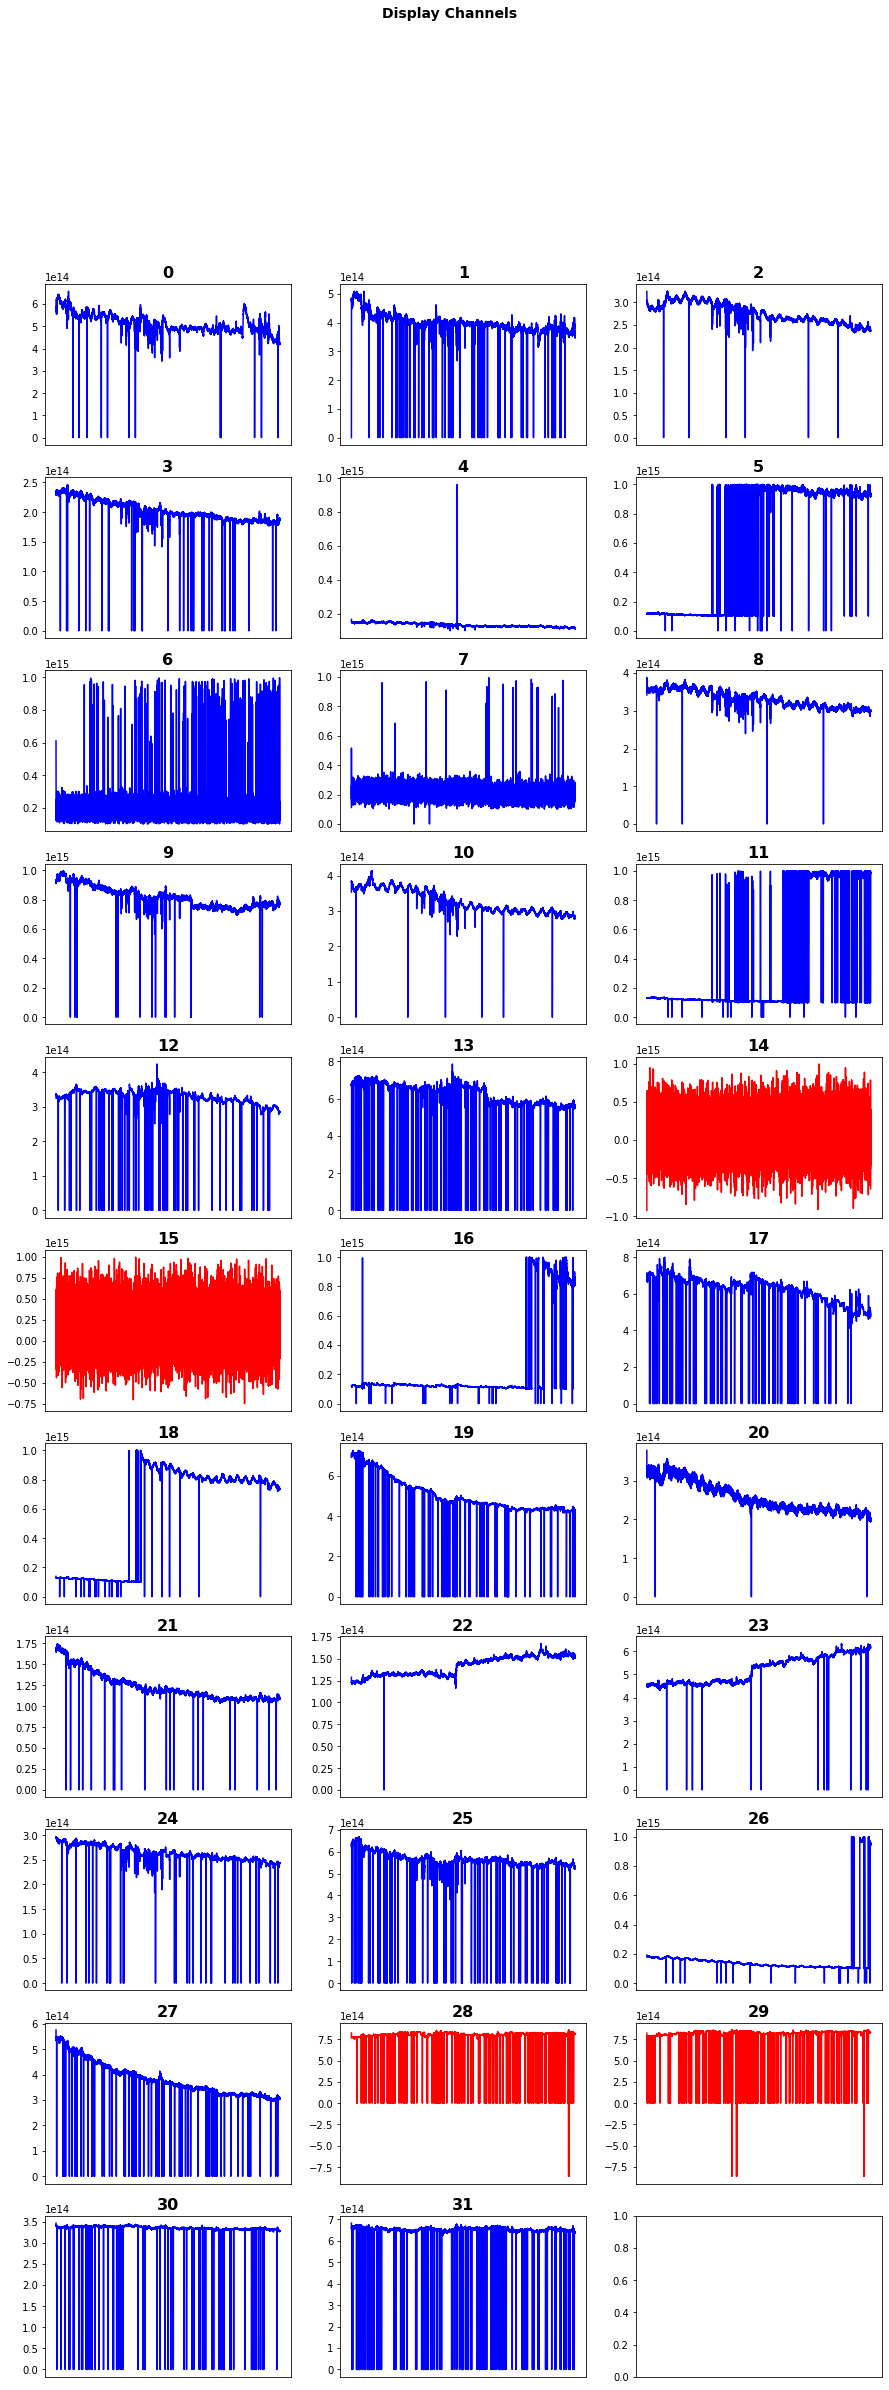

In [13]:
plotchannels(df)

# Cutted and Filtered Data



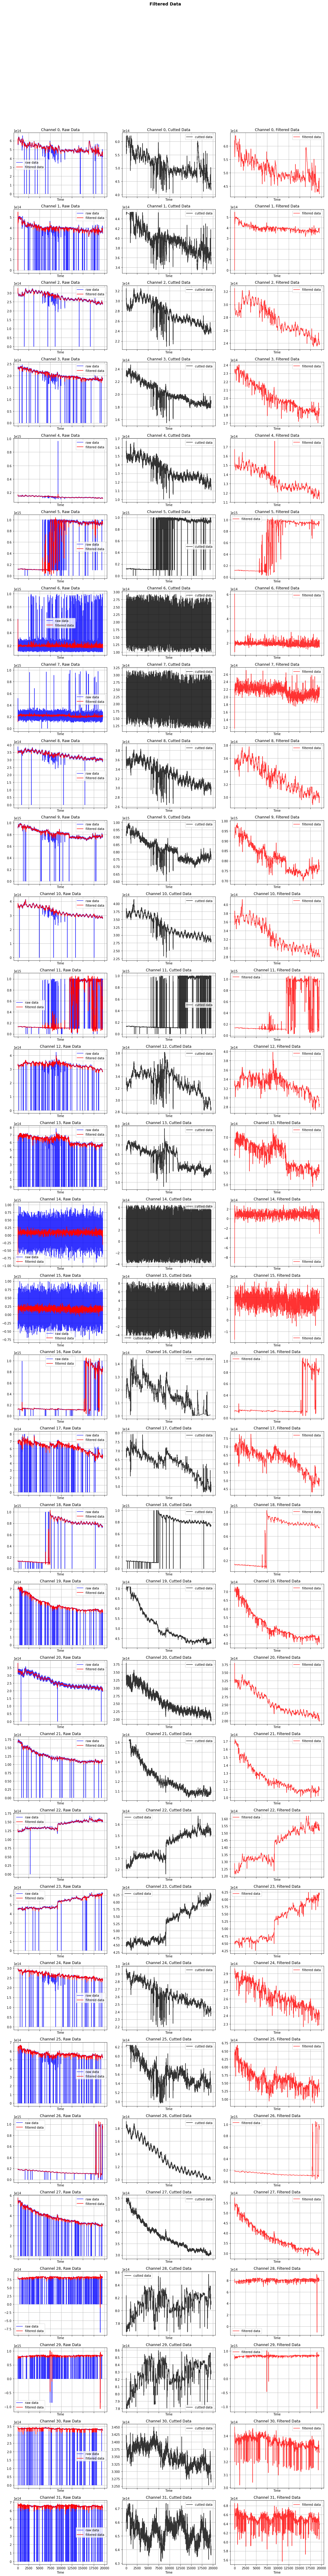

In [14]:
df_filter(df, cutoff=0.8, fs=30, order=5, title='Filtered Data')

# Data with negative values

Seems noise.

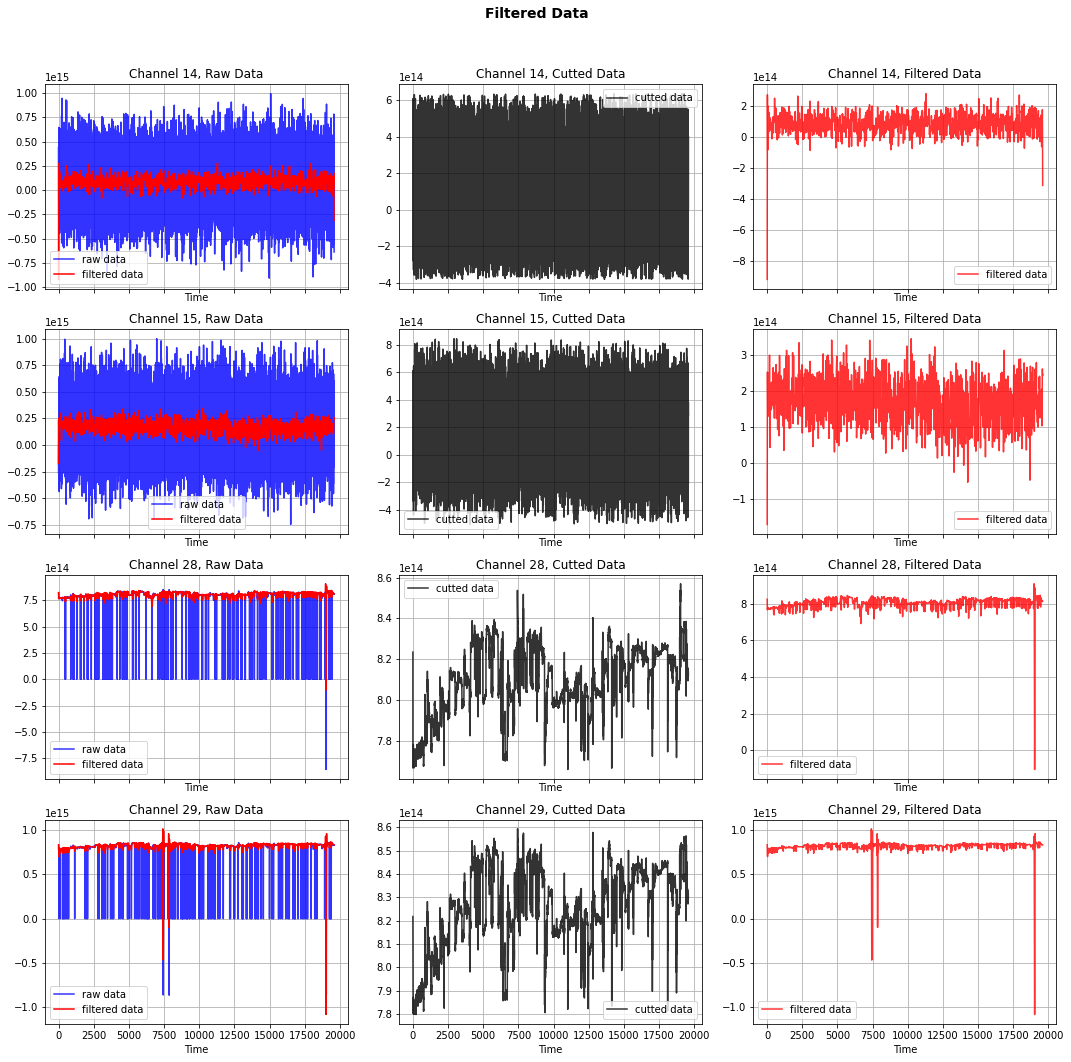

In [15]:
df_negatives = df[ list( df.columns[ df.min() < 0 ].values ) ]
df_filter(df_negatives, cutoff=0.8, fs=30, order=5, title='Filtered Data')
